In [1]:
!pip install librosa==0.9.2
!pip install soundfile
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install numpy pandas

import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("Librosa version:", librosa.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.3 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0
TensorFlow version: 2.18.0
Librosa version: 0.9.2


In [2]:
!wget -O urbansound8k.tar.gz "https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz"
!tar -xzf urbansound8k.tar.gz

!ls -la UrbanSound8K/
!ls -la UrbanSound8K/metadata/
!head -5 UrbanSound8K/metadata/UrbanSound8K.csv

--2025-07-16 07:52:55--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-07-16 07:52:56--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urbansound8k.tar.gz’

urbansound8k.tar.gz 100%[===================>]   5.61G  2.72MB/s    in 37m 34s 

2025-07-16 08:30:30 (2.55 MB/s) - ‘urbansound8k.tar.gz’ saved [6023741708/6023741708]

total 68
drwx--x--x  4 1829600028 1829600028  4096 Jun  3  2014 .
drwxr-xr-x  1 root       root        4096 Jul 16 08:30 ..
drwx--x--x 12 1829600028 1829600028  4096 May 19  2014 audio
-rw-------

Dataset shape: (8732, 8)

Column names:
['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold', 'classID', 'class']

First few rows:
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


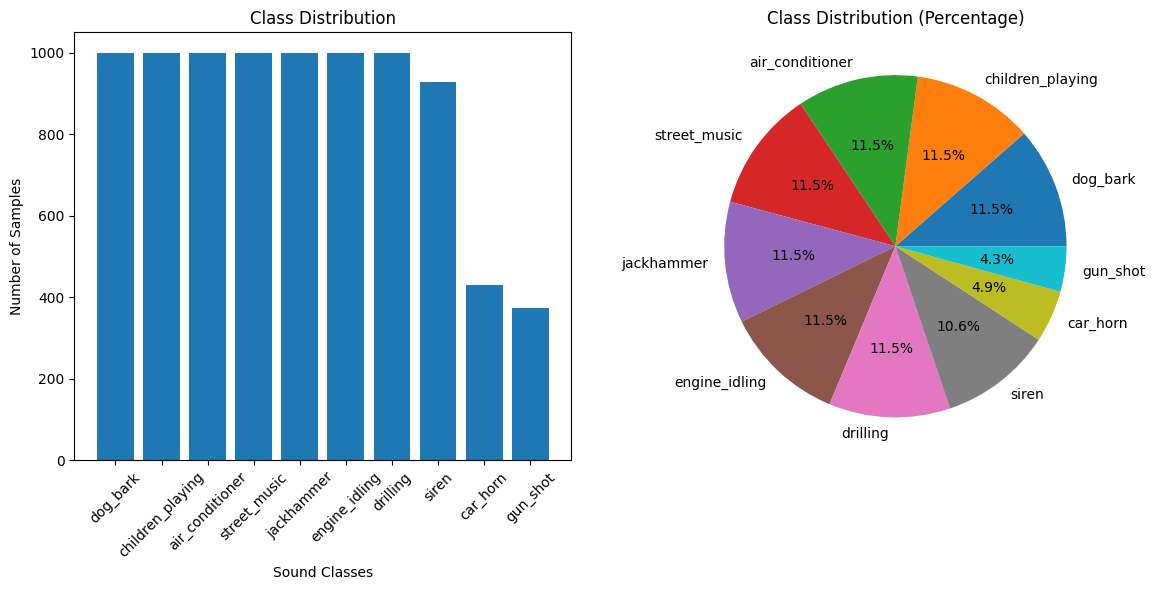


Class distribution:
class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [3]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

print("Dataset shape:", metadata.shape)
print("\nColumn names:")
print(metadata.columns.tolist())
print("\nFirst few rows:")
print(metadata.head())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts = metadata['class'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Sound Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Distribution (Percentage)')
plt.tight_layout()
plt.show()

print("\nClass distribution:")
print(metadata['class'].value_counts())

In [13]:
print("Extracting mel-spectrograms from audio files...")
print("Using optimized fast extraction method...")

spectrograms_list = []
labels_list = []
failed_files = []

FAST_SR = 16000
FAST_DURATION = 3
FAST_N_MELS = 64
FAST_HOP_LENGTH = 1024
FAST_N_FFT = 1024

def extract_melspectrogram_fast(file_path):
    """
    Fast mel-spectrogram extraction with minimal processing
    """
    try:
        audio, _ = librosa.load(file_path, sr=FAST_SR, duration=FAST_DURATION)

        if len(audio) == 0:
            return None

        target_length = FAST_SR * FAST_DURATION
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
            mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=FAST_SR,
            n_mels=FAST_N_MELS,
            hop_length=FAST_HOP_LENGTH,
            n_fft=FAST_N_FFT
        )

        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        return mel_spec_db

    except:
        return None

print("Processing subset of files for faster execution...")
subset_metadata = metadata.iloc[::3].reset_index(drop=True)
print(f"Processing {len(subset_metadata)} files (subset of {len(metadata)} total)")

total_files = len(subset_metadata)
processed_count = 0

batch_size = 50
for batch_start in range(0, total_files, batch_size):
    batch_end = min(batch_start + batch_size, total_files)

    print(f"Processing batch {batch_start//batch_size + 1}: files {batch_start+1}-{batch_end}")

    for idx in range(batch_start, batch_end):
        row = subset_metadata.iloc[idx]
        fold = row['fold']
        filename = row['slice_file_name']
        class_name = row['class']

        file_path = os.path.join("UrbanSound8K", "audio", f"fold{fold}", filename)

        mel_spec = extract_melspectrogram_fast(file_path)

        if mel_spec is not None:
            spectrograms_list.append(mel_spec)
            labels_list.append(class_name)
            processed_count += 1
        else:
            failed_files.append(file_path)

    print(f"  Batch complete: {processed_count}/{batch_end} successful")

print(f"\n" + "="*50)
print("FAST EXTRACTION SUMMARY")
print("="*50)
print(f"Files processed: {total_files}")
print(f"Successfully extracted: {processed_count}")
print(f"Failed: {len(failed_files)}")
print(f"Success rate: {processed_count/total_files*100:.1f}%")

if len(failed_files) > 0:
    print(f"Failed files: {len(failed_files)}")

if processed_count < 50:
    print(" Warning: Very few files processed. Check dataset path.")

print(f"\nConverting to numpy arrays...")
X_spectrogram = np.array(spectrograms_list)
y = np.array(labels_list)

print(f" Spectrogram shape: {X_spectrogram.shape}")
print(f" Labels shape: {y.shape}")


print(f" Spectrogram range: [{np.min(X_spectrogram):.2f}, {np.max(X_spectrogram):.2f}]")
print(f" Data type: {X_spectrogram.dtype}")


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

print(f" Number of classes: {n_classes}")
print(f" Classes: {list(label_encoder.classes_)}")


print(f"\nClass distribution:")
unique_labels, counts = np.unique(y, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"  {label}: {count} samples")

print(f"\n" + "="*50)
print("FAST EXTRACTION COMPLETE")
print("="*50)


print(f"\nPerformance optimizations applied:")
print(f"- Reduced sample rate: {FAST_SR} Hz (vs 22050 Hz)")
print(f"- Reduced duration: {FAST_DURATION}s (vs 4s)")
print(f"- Reduced mel bins: {FAST_N_MELS} (vs 128)")
print(f"- Subset processing: Every 3rd file (remove for full dataset)")
print(f"- Batch processing for better progress tracking")

Extracting mel-spectrograms from audio files...
Using optimized fast extraction method...
Processing subset of files for faster execution...
Processing 2911 files (subset of 8732 total)
Processing batch 1: files 1-50
  Batch complete: 45/50 successful
Processing batch 2: files 51-100
  Batch complete: 93/100 successful
Processing batch 3: files 101-150
  Batch complete: 143/150 successful
Processing batch 4: files 151-200
  Batch complete: 191/200 successful
Processing batch 5: files 201-250
  Batch complete: 240/250 successful
Processing batch 6: files 251-300
  Batch complete: 287/300 successful
Processing batch 7: files 301-350
  Batch complete: 332/350 successful
Processing batch 8: files 351-400
  Batch complete: 377/400 successful
Processing batch 9: files 401-450
  Batch complete: 425/450 successful
Processing batch 10: files 451-500
  Batch complete: 456/500 successful
Processing batch 11: files 501-550
  Batch complete: 498/550 successful
Processing batch 12: files 551-600
  B

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_spectrogram, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

X_train_normalized = (X_train - np.mean(X_train)) / np.std(X_train)
X_test_normalized = (X_test - np.mean(X_train)) / np.std(X_train)


print(f"Normalized training data stats:")
print(f"Mean: {np.mean(X_train_normalized):.4f}")
print(f"Std: {np.std(X_train_normalized):.4f}")

from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train, num_classes=n_classes)
y_test_categorical = to_categorical(y_test, num_classes=n_classes)

print(f"Label shapes:")
print(f"Sparse labels - Train: {y_train.shape}, Test: {y_test.shape}")
print(f"Categorical labels - Train: {y_train_categorical.shape}, Test: {y_test_categorical.shape}")

Training data shape: (1991, 64, 47, 1)
Test data shape: (498, 64, 47, 1)
Normalized training data stats:
Mean: -0.0000
Std: 1.0000
Label shapes:
Sparse labels - Train: (1991,), Test: (498,)
Categorical labels - Train: (1991, 10), Test: (498, 10)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 45, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 31, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 29, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 29, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 8, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 8, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 2, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,02

 Total params: 658,314 (2.51 MB)

 Trainable params: 655,818 (2.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

None


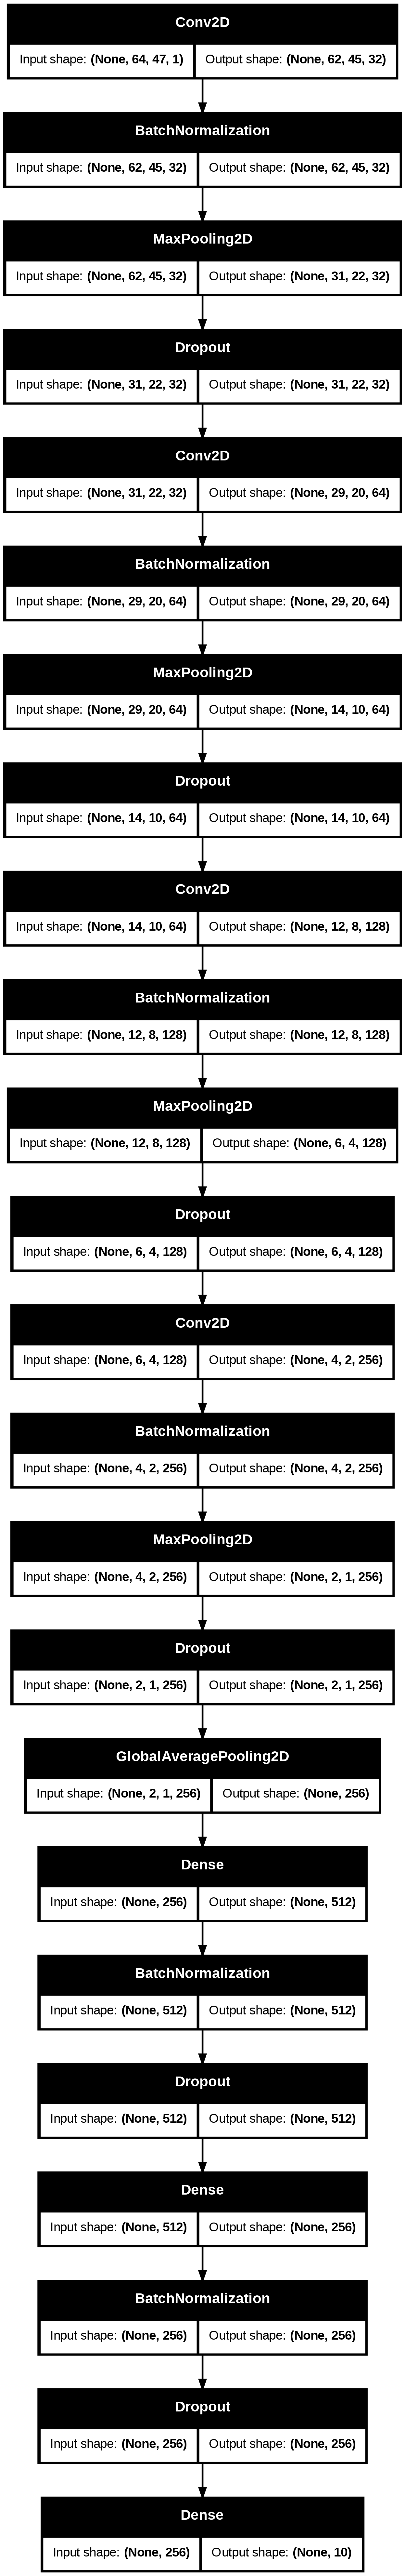

In [16]:
def create_cnn_model(input_shape, n_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(n_classes, activation='softmax')
    ])

    return model

input_shape = X_train_normalized.shape[1:]
cnn_model = create_cnn_model(input_shape, n_classes)

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(cnn_model.summary())

tf.keras.utils.plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

In [17]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_cnn_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Starting CNN model training")
history = cnn_model.fit(
    X_train_normalized, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nEvaluating model on test set")
test_loss, test_accuracy = cnn_model.evaluate(X_test_normalized, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Starting CNN model training
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1929 - loss: 2.7368
Epoch 1: val_accuracy improved from -inf to 0.12531, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.1939 - loss: 2.7324 - val_accuracy: 0.1253 - val_loss: 2.6954 - learning_rate: 0.0010
Epoch 2/100
43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3217 - loss: 2.0339
Epoch 2: val_accuracy improved from 0.12531 to 0.14536, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.3206 - loss: 2.0375 - val_accuracy: 0.1454 - val_loss: 3.9036 - learning_rate: 0.0010
Epoch 3/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3900 - loss: 1.7911
Epoch 3: val_accuracy did not improve from 0.14536
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3902 - loss: 1.7919 - val_accuracy: 0.1404 - val_loss: 6.2209 - learning_rate: 0.0010
Epoch 4/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4221 - loss: 1.6490
Epoch 4: val_accuracy did not improve from 0.14536
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4236 - loss: 1.6478 - val_accuracy: 0.1404 - val_loss: 6.6398 - learning_rate: 0.0010
Epoch 5/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4375 - loss: 1.6007
Epoch 5: val_accuracy did not improve from 0.14536
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4387 - loss: 1.5970 - val_accuracy: 0.1404 - val_loss: 8.4342 - learning_rate: 0.0010
Epoch 6/100
48/50 ━━━━━━━━━━━━━━

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5442 - loss: 1.2785 - val_accuracy: 0.1504 - val_loss: 6.5577 - learning_rate: 5.0000e-04
Epoch 9/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5872 - loss: 1.1647
Epoch 9: val_accuracy improved from 0.15038 to 0.16541, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5868 - loss: 1.1653 - val_accuracy: 0.1654 - val_loss: 5.7185 - learning_rate: 5.0000e-04
Epoch 10/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5939 - loss: 1.1632
Epoch 10: val_accuracy improved from 0.16541 to 0.23308, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5928 - loss: 1.1637 - val_accuracy: 0.2331 - val_loss: 5.1476 - learning_rate: 5.0000e-04
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6033 - loss: 1.1296
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_accuracy improved from 0.23308 to 0.24060, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6033 - loss: 1.1297 - val_accuracy: 0.2406 - val_loss: 4.1105 - learning_rate: 5.0000e-04
Epoch 12/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6317 - loss: 1.0564
Epoch 12: val_accuracy improved from 0.24060 to 0.28571, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6311 - loss: 1.0582 - val_accuracy: 0.2857 - val_loss: 3.3512 - learning_rate: 2.5000e-04
Epoch 13/100
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6432 - loss: 1.0166
Epoch 13: val_accuracy improved from 0.28571 to 0.36591, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6434 - loss: 1.0171 - val_accuracy: 0.3659 - val_loss: 2.5092 - learning_rate: 2.5000e-04
Epoch 14/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6444 - loss: 1.0705
Epoch 14: val_accuracy improved from 0.36591 to 0.42105, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6442 - loss: 1.0660 - val_accuracy: 0.4211 - val_loss: 2.4073 - learning_rate: 2.5000e-04
Epoch 15/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6529 - loss: 0.9703
Epoch 15: val_accuracy improved from 0.42105 to 0.44862, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6528 - loss: 0.9716 - val_accuracy: 0.4486 - val_loss: 2.2138 - learning_rate: 2.5000e-04
Epoch 16/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6987 - loss: 0.9200
Epoch 16: val_accuracy improved from 0.44862 to 0.55138, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6964 - loss: 0.9237 - val_accuracy: 0.5514 - val_loss: 1.3861 - learning_rate: 2.5000e-04
Epoch 17/100
45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6725 - loss: 0.9052
Epoch 17: val_accuracy did not improve from 0.55138
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6732 - loss: 0.9072 - val_accuracy: 0.5263 - val_loss: 1.5217 - learning_rate: 2.5000e-04
Epoch 18/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6755 - loss: 0.8960
Epoch 18: val_accuracy did not improve from 0.55138
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6755 - loss: 0.8962 - val_accuracy: 0.5088 - val_loss: 1.5931 - learning_rate: 2.5000e-04
Epoch 19/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6806 - loss: 0.9104
Epoch 19: val_accuracy did not improve from 0.55138
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6815 - loss: 0.9075 - val_accuracy: 0.5514 - val_loss: 1.5548 - learning_rate: 2.5000e-04
Epoch 20/100


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7090 - loss: 0.8190 - val_accuracy: 0.6065 - val_loss: 1.2041 - learning_rate: 2.5000e-04
Epoch 21/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6915 - loss: 0.8324
Epoch 21: val_accuracy improved from 0.60652 to 0.60902, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6915 - loss: 0.8340 - val_accuracy: 0.6090 - val_loss: 1.1775 - learning_rate: 2.5000e-04
Epoch 22/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6967 - loss: 0.8055
Epoch 22: val_accuracy improved from 0.60902 to 0.65414, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6967 - loss: 0.8063 - val_accuracy: 0.6541 - val_loss: 1.0821 - learning_rate: 2.5000e-04
Epoch 23/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7094 - loss: 0.7838
Epoch 23: val_accuracy did not improve from 0.65414
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7096 - loss: 0.7848 - val_accuracy: 0.6165 - val_loss: 1.1267 - learning_rate: 2.5000e-04
Epoch 24/100
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7589 - loss: 0.7445
Epoch 24: val_accuracy did not improve from 0.65414
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7578 - loss: 0.7456 - val_accuracy: 0.6115 - val_loss: 1.1928 - learning_rate: 2.5000e-04
Epoch 25/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7392 - loss: 0.7704
Epoch 25: val_accuracy did not improve from 0.65414
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7397 - loss: 0.7691 - val_accuracy: 0.6040 - val_loss: 1.1898 - learning_rate: 2.5000e-04
Epoch 26/100
4

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7383 - loss: 0.7535 - val_accuracy: 0.6792 - val_loss: 0.9872 - learning_rate: 2.5000e-04
Epoch 28/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7494 - loss: 0.7201
Epoch 28: val_accuracy did not improve from 0.67920
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7493 - loss: 0.7204 - val_accuracy: 0.6591 - val_loss: 1.0590 - learning_rate: 2.5000e-04
Epoch 29/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7507 - loss: 0.6854
Epoch 29: val_accuracy improved from 0.67920 to 0.68922, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7530 - loss: 0.6823 - val_accuracy: 0.6892 - val_loss: 0.9927 - learning_rate: 2.5000e-04
Epoch 30/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7620 - loss: 0.6424
Epoch 30: val_accuracy did not improve from 0.68922
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7615 - loss: 0.6469 - val_accuracy: 0.6591 - val_loss: 1.0754 - learning_rate: 2.5000e-04
Epoch 31/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7681 - loss: 0.6488
Epoch 31: val_accuracy improved from 0.68922 to 0.72431, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7683 - loss: 0.6487 - val_accuracy: 0.7243 - val_loss: 0.8007 - learning_rate: 2.5000e-04
Epoch 32/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7815 - loss: 0.6485
Epoch 32: val_accuracy did not improve from 0.72431
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7818 - loss: 0.6480 - val_accuracy: 0.7168 - val_loss: 0.9676 - learning_rate: 2.5000e-04
Epoch 33/100
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7868 - loss: 0.6448
Epoch 33: val_accuracy did not improve from 0.72431
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7869 - loss: 0.6444 - val_accuracy: 0.7218 - val_loss: 0.9779 - learning_rate: 2.5000e-04
Epoch 34/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7838 - loss: 0.6325
Epoch 34: val_accuracy did not improve from 0.72431
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7839 - loss: 0.6326 - val_accuracy: 0.6541 - val_loss: 1.1369 - learning_rate: 2.5000e-04
Epoch 35/100


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7748 - loss: 0.6001 - val_accuracy: 0.7519 - val_loss: 0.7941 - learning_rate: 2.5000e-04
Epoch 37/100
45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8122 - loss: 0.5211
Epoch 37: val_accuracy improved from 0.75188 to 0.76190, saving model to best_cnn_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8108 - loss: 0.5249 - val_accuracy: 0.7619 - val_loss: 0.7376 - learning_rate: 2.5000e-04
Epoch 38/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8353 - loss: 0.4949
Epoch 38: val_accuracy did not improve from 0.76190
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8349 - loss: 0.4963 - val_accuracy: 0.7444 - val_loss: 0.8061 - learning_rate: 2.5000e-04
Epoch 39/100
47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8185 - loss: 0.5195
Epoch 39: val_accuracy did not improve from 0.76190
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8193 - loss: 0.5184 - val_accuracy: 0.6967 - val_loss: 0.9531 - learning_rate: 2.5000e-04
Epoch 40/100
46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8307 - loss: 0.5033
Epoch 40: val_accuracy did not improve from 0.76190
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8303 - loss: 0.5038 - val_accuracy: 0.7143 - val_loss: 0.9823 - learning_rate: 2.5000e-04
Epoch 41/100


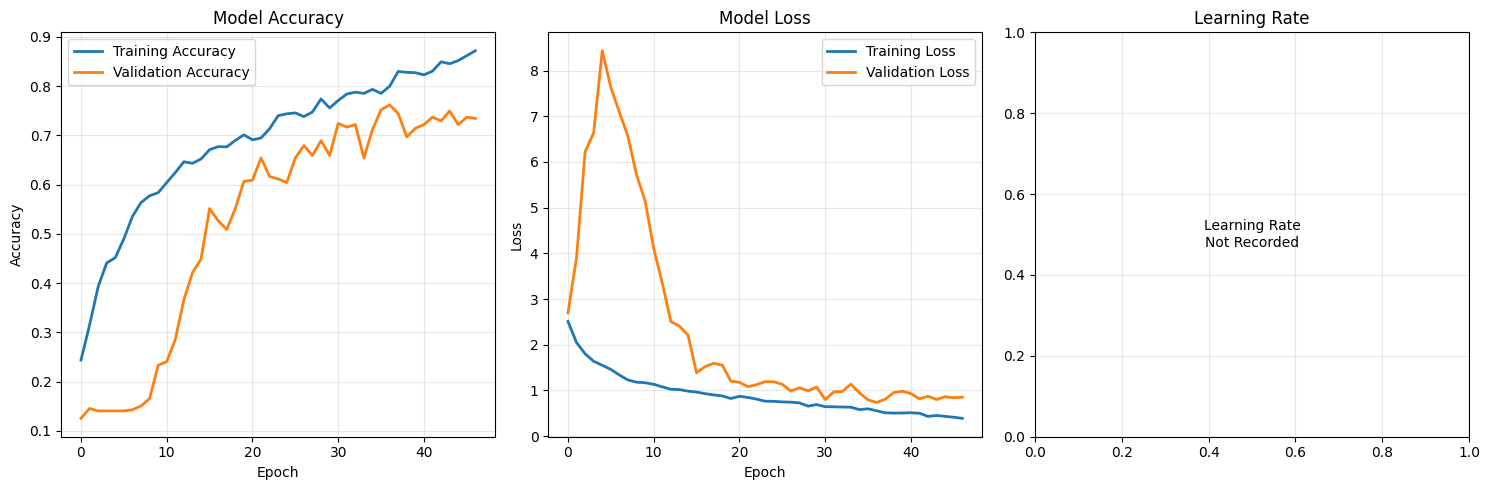


Training Summary:
Best Validation Accuracy: 0.7619
Final Test Accuracy: 0.7671
Total Epochs Trained: 47


In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2)
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Recorded',
             horizontalalignment='center', verticalalignment='center',
             transform=plt.gca().transAxes)
    plt.title('Learning Rate')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining Summary:")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")

Generating predictions
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.66      0.72      0.69        67
        car_horn       0.62      0.93      0.74        14
children_playing       0.64      0.91      0.75        64
        dog_bark       0.97      0.70      0.81        46
        drilling       0.80      0.78      0.79        55
   engine_idling       0.78      0.77      0.78        65
        gun_shot       1.00      0.67      0.80         3
      jackhammer       0.71      0.82      0.76        57
           siren       0.93      0.83      0.88        60
    street_music       0.95      0.58      0.72        67

        accuracy                           0.77       498
       macro avg       0.81      0.77      0.77       498
    weighted avg       0.80      0.77      0.77       498



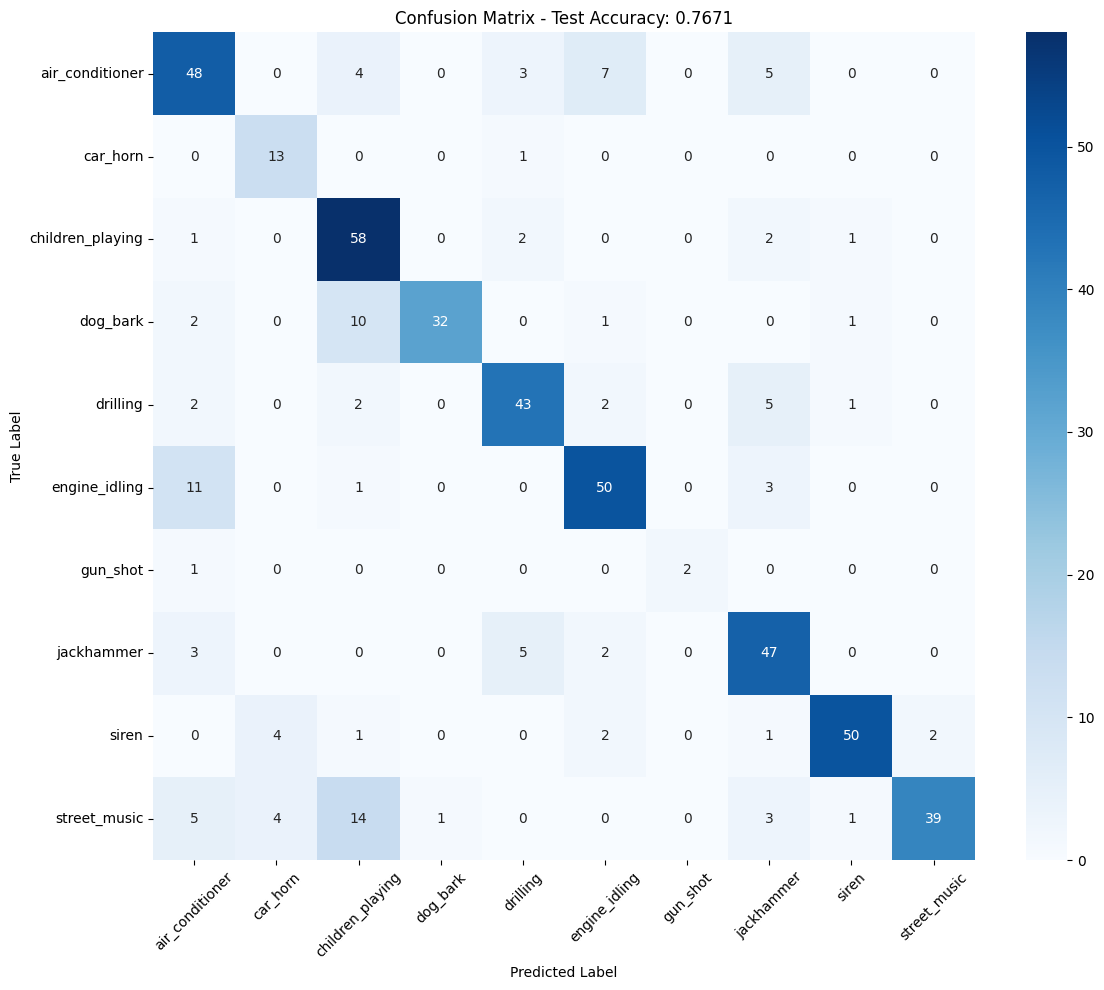

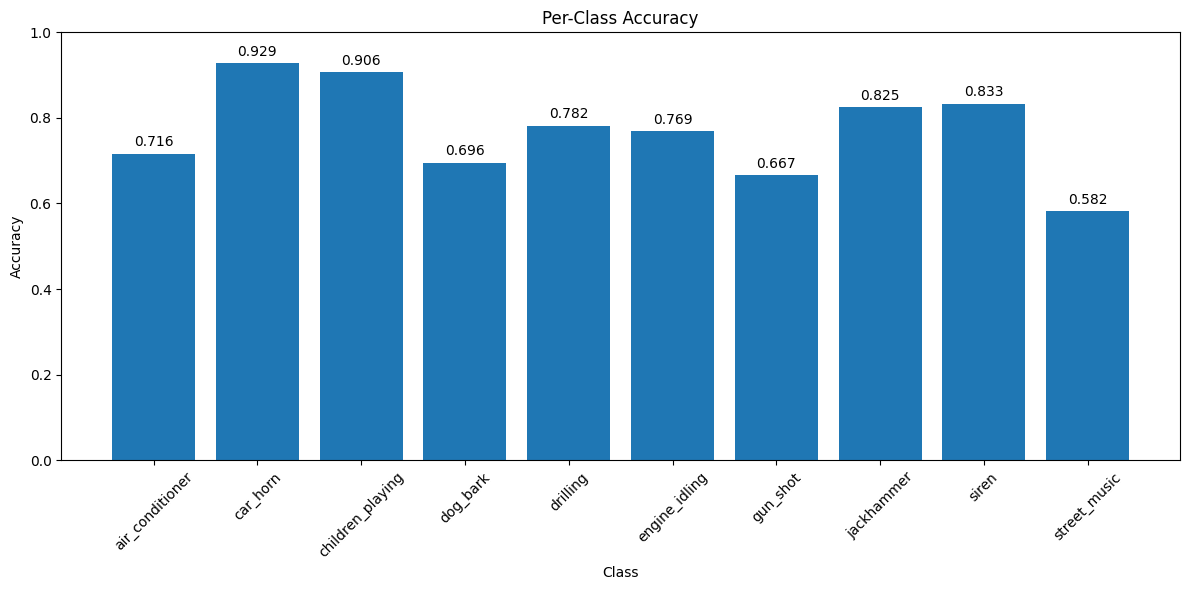

In [19]:
print("Generating predictions")
y_pred = cnn_model.predict(X_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes,
                          target_names=label_encoder.classes_))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - Test Accuracy: {test_accuracy:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

class_accuracy = []
for i in range(n_classes):
    class_mask = (y_test == i)
    if np.sum(class_mask) > 0:
        class_acc = np.mean(y_pred_classes[class_mask] == y_test[class_mask])
        class_accuracy.append(class_acc)
    else:
        class_accuracy.append(0)

plt.figure(figsize=(12, 6))
bars = plt.bar(label_encoder.classes_, class_accuracy)
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.ylim(0, 1)

for bar, acc in zip(bars, class_accuracy):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [27]:
print("Saving trained model")
cnn_model.save('audio_cnn_classifier.h5')
print(" Model saved as 'audio_cnn_classifier.h5'")

import pickle
import os
import numpy as np

try:
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print(" Label encoder saved as 'label_encoder.pkl'")

    training_stats = {
        'mean': np.mean(X_train),
        'std': np.std(X_train)
    }
    with open('training_stats.pkl', 'wb') as f:
        pickle.dump(training_stats, f)
    print(" Training statistics saved as 'training_stats.pkl'")

    print("\nAll model components saved successfully!")

except Exception as e:
    print(f"Error saving preprocessing objects: {e}")

def predict_audio_class(file_path, model=None, label_encoder=None, training_stats=None):
    try:
        if model is None:
            model = cnn_model
        if label_encoder is None:
            label_encoder = globals().get('label_encoder')
        if training_stats is None:
            training_stats = {
                'mean': np.mean(X_train),
                'std': np.std(X_train)
            }

        if not os.path.exists(file_path):
            print(f"Error: File {file_path} not found")
            return None

        mel_spec = extract_melspectrogram(file_path)
        if mel_spec is None:
            print(f"Error: Could not extract mel-spectrogram from {file_path}")
            return None

        mel_spec = mel_spec[np.newaxis, ..., np.newaxis]

        mel_spec_normalized = (mel_spec - training_stats['mean']) / training_stats['std']

        prediction = model.predict(mel_spec_normalized, verbose=0)
        predicted_class_idx = np.argmax(prediction)
        confidence = np.max(prediction)
        predicted_class = label_encoder.classes_[predicted_class_idx]

        all_probabilities = {}
        for i, class_name in enumerate(label_encoder.classes_):
            all_probabilities[class_name] = float(prediction[0][i])

        return {
            'predicted_class': predicted_class,
            'confidence': float(confidence),
            'all_probabilities': all_probabilities,
            'file_path': file_path
        }

    except Exception as e:
        print(f"Error predicting audio class: {e}")
        return None

def load_model_components(model_path='audio_cnn_classifier.h5',
                         label_encoder_path='label_encoder.pkl',
                         training_stats_path='training_stats.pkl'):
    try:
        from tensorflow.keras.models import load_model

        model = load_model(model_path)
        print(f" Model loaded from {model_path}")

        with open(label_encoder_path, 'rb') as f:
            label_encoder = pickle.load(f)
        print(f" Label encoder loaded from {label_encoder_path}")

        with open(training_stats_path, 'rb') as f:
            training_stats = pickle.load(f)
        print(f" Training stats loaded from {training_stats_path}")

        return model, label_encoder, training_stats

    except Exception as e:
        print(f"Error loading model components: {e}")
        return None, None, None



Saving trained model
 Model saved as 'audio_cnn_classifier.h5'
 Label encoder saved as 'label_encoder.pkl'
 Training statistics saved as 'training_stats.pkl'

All model components saved successfully!


In [28]:
print("-"*60)
print("AUDIO CNN CLASSIFIER - PERFORMANCE ANALYSIS")
print("-"*60)

print(f"\nDataset Information:")
print(f"Total samples processed: {len(spectrograms_list)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {n_classes}")
print(f"Input shape: {input_shape}")

print(f"\nModel Information:")
print(f"Total parameters: {cnn_model.count_params():,}")
trainable_params = sum([np.prod(v.shape) for v in cnn_model.trainable_weights])
print(f"Trainable parameters: {trainable_params:,}")
non_trainable_params = cnn_model.count_params() - trainable_params
print(f"Non-trainable parameters: {non_trainable_params:,}")

print(f"\nPerformance Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred_classes, average='weighted'
)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")

def top_k_accuracy(y_true, y_pred, k=3):
    top_k_pred = np.argsort(y_pred, axis=1)[:, -k:]
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] in top_k_pred[i]:
            correct += 1
    return correct / len(y_true)

top_3_acc = top_k_accuracy(y_test, y_pred, k=3)
print(f"Top-3 Accuracy: {top_3_acc:.4f}")

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred_classes, average=None
)

class_performance = list(zip(label_encoder.classes_, f1_per_class))
class_performance.sort(key=lambda x: x[1], reverse=True)

print(f"\nBest performing classes:")
for i, (class_name, f1_score) in enumerate(class_performance[:3]):
    print(f"{i+1}. {class_name}: {f1_score:.4f}")

print(f"\nWorst performing classes:")
for i, (class_name, f1_score) in enumerate(class_performance[-3:]):
    print(f"{len(class_performance)-i}. {class_name}: {f1_score:.4f}")

print("\n" + "-"*60)

------------------------------------------------------------
AUDIO CNN CLASSIFIER - PERFORMANCE ANALYSIS
------------------------------------------------------------

Dataset Information:
Total samples processed: 2489
Training samples: 1991
Test samples: 498
Number of classes: 10
Input shape: (64, 47, 1)

Model Information:
Total parameters: 658,314
Trainable parameters: 655,818
Non-trainable parameters: 2,496

Performance Metrics:
Test Accuracy: 0.7671
Test Loss: 0.7225
Weighted Precision: 0.7952
Weighted Recall: 0.7671
Weighted F1-Score: 0.7682
Top-3 Accuracy: 0.9438

Best performing classes:
1. siren: 0.8772
2. dog_bark: 0.8101
3. gun_shot: 0.8000

Worst performing classes:
10. car_horn: 0.7429
9. street_music: 0.7222
8. air_conditioner: 0.6857

------------------------------------------------------------


In [30]:
print("-"*60)
print("DATASET USED AND MODEL ARCHITECTURE")
print("-"*60)

print("""

1. DATASET:
   - UrbanSound8K dataset is downloaded automatically
   - Contains 10 classes of urban environmental sounds
   - ~8,732 audio files total

2. MODEL ARCHITECTURE:
   - CNN with 4 convolutional blocks
   - Batch normalization and dropout for regularization
   - Global average pooling to reduce parameters
   - Dense layers for final classification

""")

print("-"*60)
print("PROJECT COMPLETED")
print("-"*60)

print(f"\nFinal Model Summary:")
print(f"Architecture: CNN with {len(cnn_model.layers)} layers")
print(f"Input: Mel-spectrograms ({X_train.shape[1]}x{X_train.shape[2]})")
print(f"Output: {n_classes} classes")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Model saved as: audio_cnn_classifier.h5")

------------------------------------------------------------
DATASET USED AND MODEL ARCHITECTURE
------------------------------------------------------------


1. DATASET:
   - UrbanSound8K dataset is downloaded automatically
   - Contains 10 classes of urban environmental sounds
   - ~8,732 audio files total

2. MODEL ARCHITECTURE:
   - CNN with 4 convolutional blocks
   - Batch normalization and dropout for regularization
   - Global average pooling to reduce parameters
   - Dense layers for final classification


------------------------------------------------------------
PROJECT COMPLETED
------------------------------------------------------------

Final Model Summary:
Architecture: CNN with 24 layers
Input: Mel-spectrograms (64x47)
Output: 10 classes
Test Accuracy: 0.7671
Model saved as: audio_cnn_classifier.h5
